# Transfer Learning in Tensorflow - Part 1

## Feature Extraction

### Lead the data and get one with it

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

main_data_dir = '10_food_classes_10_percent'

zip_ref = zipfile.ZipFile(main_data_dir+'.zip')
zip_ref.extractall()
zip_ref.close()

--2021-10-27 13:01:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   110MB/s    in 1.5s    

2021-10-27 13:01:14 (110 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
os.chdir('/content/')
# walk through the pizza steak directory and list files
# the strange images are because of the hidden files in the directories
for dirpath, dirname, filename in os.walk(main_data_dir):
  print(f'there are {len(dirname)} directories and {len(filename)} images in {dirpath}.')

there are 2 directories and 0 images in 10_food_classes_10_percent.
there are 10 directories and 0 images in 10_food_classes_10_percent/train.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/steak.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings.
there are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice.
there are

In [ ]:
# IMPORTS
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# preprocessing data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# setup paths
train_dir = f'/content/{main_data_dir}/train'
test_dir = f'/content/{main_data_dir}/test'

# import the data from dirs and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='categorical',
                                               seed=711)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='categorical',
                                               seed=711)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


#### A remark on tensorflow callbacks

##### Creating a tensorboard callback

In [ ]:
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')
  return tensorboard_callback

### Loading a model from tensorflow hub

In [ ]:
# Create a model from the tensorflow hub link
def create_model(url, num_classes=10):
  # load the layer from efficient net
  feature_extractor_layer = hub.KerasLayer(url, trainable=False,input_shape=(224,224,3))

  model = tf.keras.Sequential([
      feature_extractor_layer,  # Can be True, see below.
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  return model

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

#### Create ResNet model

In [ ]:
# 1. get the model
resnet_model = create_model(resnet_url,num_classes=train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# 2. compile the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history_resnet = resnet_model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=valid_data,validation_steps=len(valid_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='resnet50v2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20211027-130143
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.9514 - accuracy: 0.3560 - val_loss: 1.2873 - val_accuracy: 0.5728
Epoch 2/5
24/24 [==============================] - 21s 913ms/step - loss: 0.9433 - accuracy: 0.7253 - val_loss: 0.8756 - val_accuracy: 0.7104
Epoch 3/5
24/24 [==============================] - 22s 928ms/step - loss: 0.6544 - accuracy: 0.8253 - val_loss: 0.7962 - val_accuracy: 0.7420
Epoch 4/5
24/24 [==============================] - 22s 932ms/step - loss: 0.4961 - accuracy: 0.8693 - val_loss: 0.7230 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 22s 933ms/step - loss: 0.3982 - accuracy: 0.9080 - val_loss: 0.6958 - val_accuracy: 0.7768


In [ ]:
# plot loss and training curves
def plot_acc_and_loss(history, lrs = False, epochs = 5):
  df = pd.DataFrame(history.history)
  df[[col for col in df.columns if 'acc' in col]].plot(figsize=(8,8))
  plt.title('Training and Validation Accuracy while Training')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
  df[[col for col in df.columns if 'loss' in col]].plot(figsize=(8,8))
  plt.title('Loss and Validation Loss while Training')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
  if lrs: 
    lr = lambda epoch: 1e-3 * 10**(epoch/(epochs/2))
    learning_rates = lr(np.arange(1,epochs+1))
    plt.semilogx(
        learning_rates, 
        history.history['loss'], 
        lw=3, color='#000'
    )
    plt.title('Learning rate vs. loss', size=20)
    plt.xlabel('Learning rate', size=14)
    plt.ylabel('Loss', size=14);

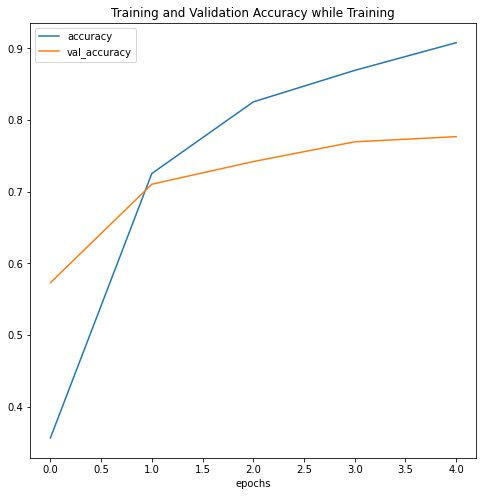

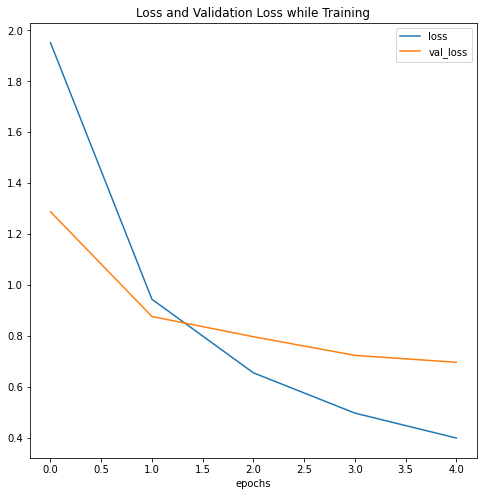

In [ ]:
plot_acc_and_loss(history_resnet)

#### Create EfficientNet model

In [ ]:
efficientnet_model = create_model(efficientnet_url,num_classes=train_data.num_classes)

In [ ]:
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              4049564   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
history_efficientnet = efficientnet_model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=valid_data,validation_steps=len(valid_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='efficientnetb0')])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20211027-131031
Epoch 1/5
24/24 [==============================] - 33s 988ms/step - loss: 1.8963 - accuracy: 0.4213 - val_loss: 1.3102 - val_accuracy: 0.7304
Epoch 2/5
24/24 [==============================] - 19s 805ms/step - loss: 1.0755 - accuracy: 0.7680 - val_loss: 0.8742 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 18s 790ms/step - loss: 0.7624 - accuracy: 0.8413 - val_loss: 0.6987 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 18s 792ms/step - loss: 0.6131 - accuracy: 0.8747 - val_loss: 0.6082 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 19s 796ms/step - loss: 0.5136 - accuracy: 0.8907 - val_loss: 0.5547 - val_accuracy: 0.8660


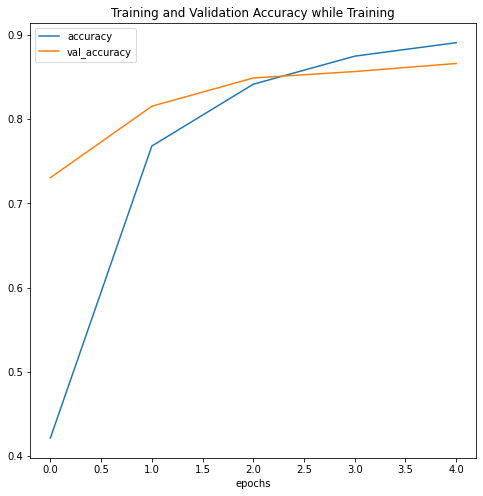

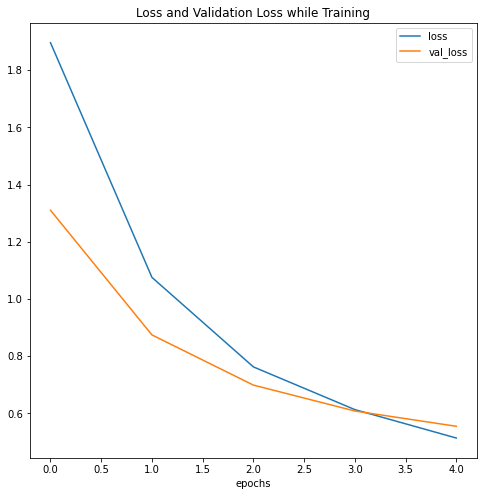

In [ ]:
plot_acc_and_loss(history_efficientnet)

### Comparing models using tensorboard

In [ ]:
# upload tensorboard.dev records
!tensorboard dev upload \
--logdir ./tensorflow_hub/ \
--name "EfficientNet B0 vs ResNet50V2" \
--description "compare the 2 models" \
--one_shot

2021-10-27 13:38:55.670335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 13:38:55.698976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 13:38:55.699458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

In [ ]:
!tensorboard dev list

2021-10-27 13:45:17.548340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 13:45:17.557301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 13:45:17.557825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/sAf3Lsd9SdiMlNzRzJBnJA/
	Name                 EfficientNet B0 vs ResNet50V2
	Description          compare the 2 models
	Id                   sAf3Lsd9SdiMlNzRzJBnJA
	Created              2021-10-27 13:39:41 (5 minutes ago)
	Updated              2021-10-27 13:39:43 (5 minutes ago)
	Runs                 4
	